In [53]:
%reload_ext autoreload
#%load_ext autoreload
%autoreload 1
%matplotlib inline

import datetime
import pandas as pd
#import modin.pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm import tqdm


#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import os
import sys
import gc
import joblib

os.chdir("T:\\laupodteam\\AIOS\\Bram\\notebooks\\code_dev\\celldyn_embedder\\sandbox")
#os.chdir("/media/UMCU/notebooks/code_dev/celldyn_embedder/sandbox")
sns.set_style("whitegrid")

write_to_disk = False
read_from_disk = True

from numba import njit, float32
from numpy import linalg as la
#import ray
#ray.init()

from hembedder.utils.distance import poincarre_dist, fractional_distance, hyperboloid_dist, Distance

In [2]:
#@njit(float32(float32[:],float32[:]), fastmath=True)
#def poincarre_dist(x,y):
#    return np.arccosh(\
#    1 + 2*(\
#        la.norm(x-y,ord = 2)**2/((1-la.norm(x,ord = 2)**2)*(1-la.norm(y,ord = 2)**2))
#        )
#    )
#@njit(float32(float32[:],float32[:], float32), fastmath=True)
#def fractional_distance(x, y, f=0.5):
#    return np.power(np.abs(np.sum(np.power(x-y, f))), 1/f)

In [3]:
#cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_cleaned_transformed_imputed_ALL_with_ratios.feather"
#cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_FULL_transformed_df.feather"
cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_checked.feather"
celldyn = pd.read_feather(cpath)
celldyn.columns = celldyn.columns.str.lower()


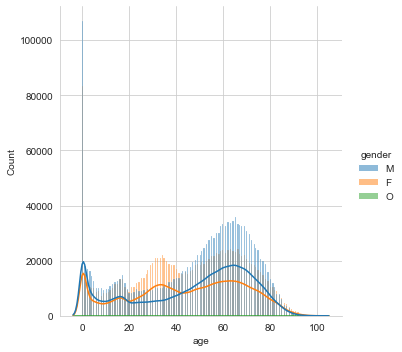

In [4]:
sns.displot(data=celldyn, x='age', hue='gender', kde=True)

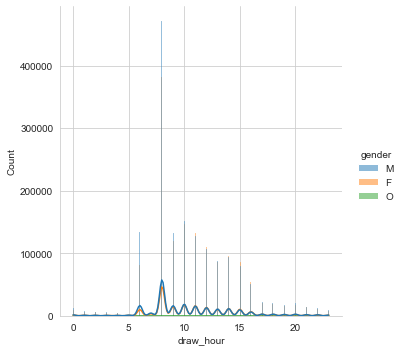

In [5]:
sns.displot(data=celldyn, x='draw_hour', hue='gender', kde=True)

### Patients who have measurements in the evening and during the day

In [6]:
meas_per_patient = celldyn.shape[0]/celldyn.studyid_alle_celldyn.nunique()
print(f"There are on average {meas_per_patient} measurements per patient")

There are on average 8.627080928240392 measurements per patient


In [7]:
counts_per_patient = pd.DataFrame(celldyn.groupby('studyid_alle_celldyn').size(),  
                        columns=['counts_per_patient'])
celldyn = celldyn.merge(counts_per_patient.reset_index(), how='left', on='studyid_alle_celldyn')

In [8]:
meta_cols = ['asp_dt', 'analyzer', 'studyid_alle_celldyn', 
             'time_to_measurement', 'gender', 'age' , 'afname_dt',
             'day_of_year', 'week_of_year', 'year', 'first_day',
              'draw_hour', 'meas_hour', 'draw_minute', 'draw_hour_dec']

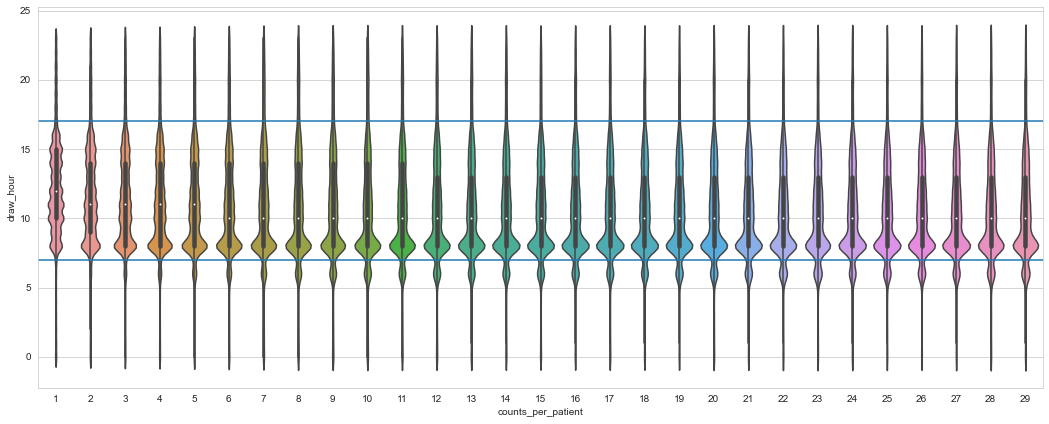

In [9]:
fig, ax = plt.subplots(figsize=(18,7))
sns.violinplot(data=celldyn[celldyn.counts_per_patient<30], x='counts_per_patient', y='draw_hour')
plt.axhline(7)
plt.axhline(17)

There are three blocks: 
* routine block: from 7AM to 5PM, mostly poli perhaps?
* evening block: from 5PM to 12PM
* morning block: from 12PM to 7AM

In [10]:
celldyn.loc[:,'care_block'] = celldyn.apply(lambda x: 'routine_block'\
                                    if (x['draw_hour']>=7) & (x['draw_hour']<17)
                                    else 'evening_block' if (x['draw_hour']>=17) & (x['draw_hour']<=23)
                                    else 'morning_block', axis=1
)
meta_cols.append('care_block')
celldyn = celldyn.assign(draw_minute=celldyn.afname_dt.dt.minute)

In [11]:
celldyn = celldyn.assign(draw_hour_dec=celldyn[['draw_hour', 'draw_minute']].apply(lambda x: round(x[0]+x[1]/60, 1), axis=1))
meas_cols =[c for c in celldyn.columns if 'c_b_' in c or ':' in c]

In [12]:
# function to set all values to their 1st and 99th percentile
def clip_outliers(df, cols, qL=0.01, qH=0.99):
    for col in cols:
        df.loc[:,col] = df[col].clip(df[col].quantile(qL), df[col].quantile(qH))
    return df

Text(0.5, 0.98, 'Hourly variation in granulocytes')

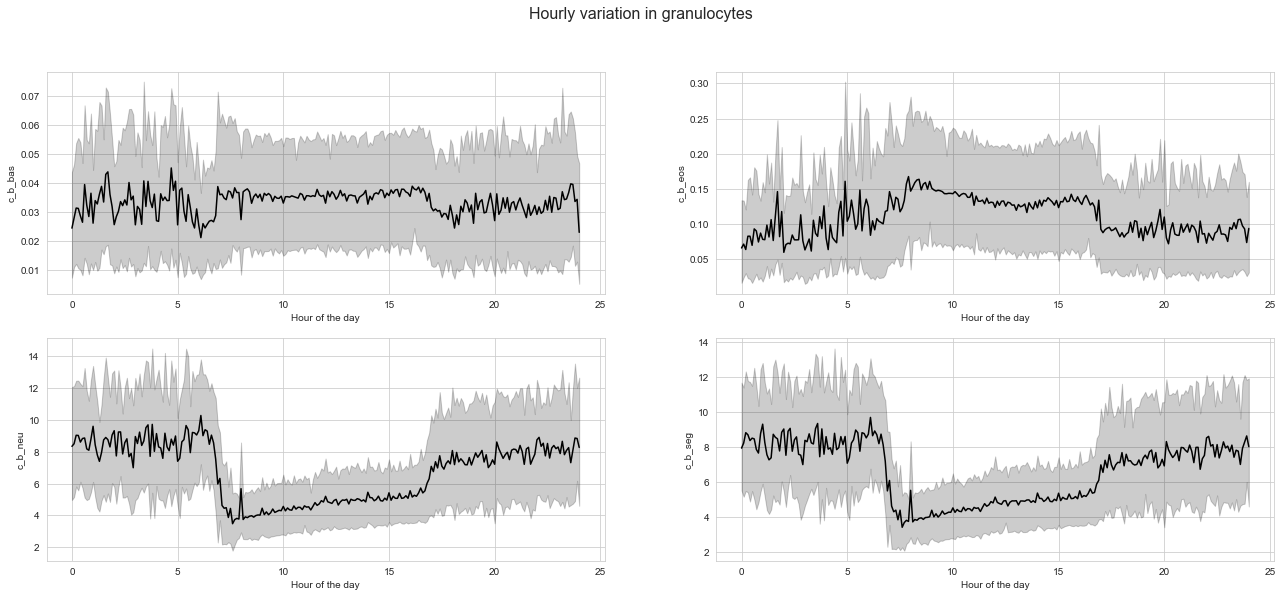

In [13]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_bas.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_eos.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_neu.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_seg.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

plot_df.rename(columns={'level_1': 'percentile'}, inplace=True)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_bas', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_eos', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_neu', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_seg', color='black', ax=ax[1,1])

ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

plt.suptitle('Hourly variation in granulocytes', fontsize=16)

Text(0.5, 0.98, 'Hourly variation in agranulocytes')

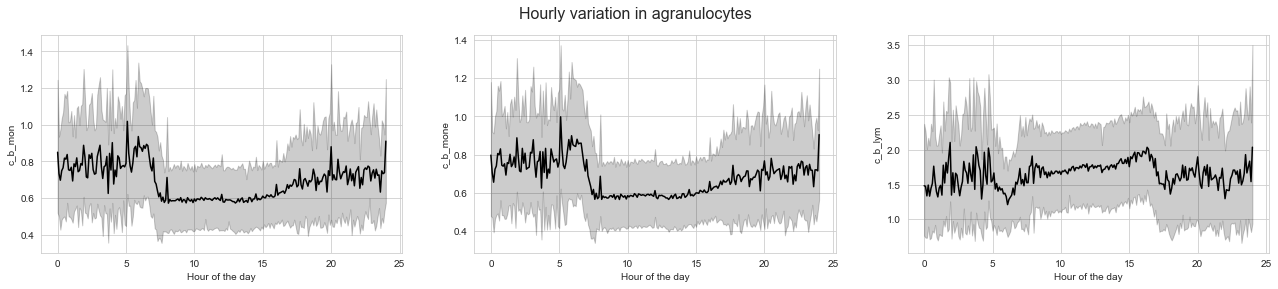

In [14]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_mon.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_mone.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_lym.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
plot_df.rename(columns={'level_1': 'percentile'}, inplace=True)

fig, ax = plt.subplots(ncols=3, figsize=(22,4))
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mon', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mone', color='black', ax=ax[1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_lym', color='black', ax=ax[2])
# seg
ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')
ax[2].set_xlabel('Hour of the day')

plt.suptitle('Hourly variation in agranulocytes', fontsize=16)

Text(0.5, 0.98, 'Hourly variation in red/white blood cells ')

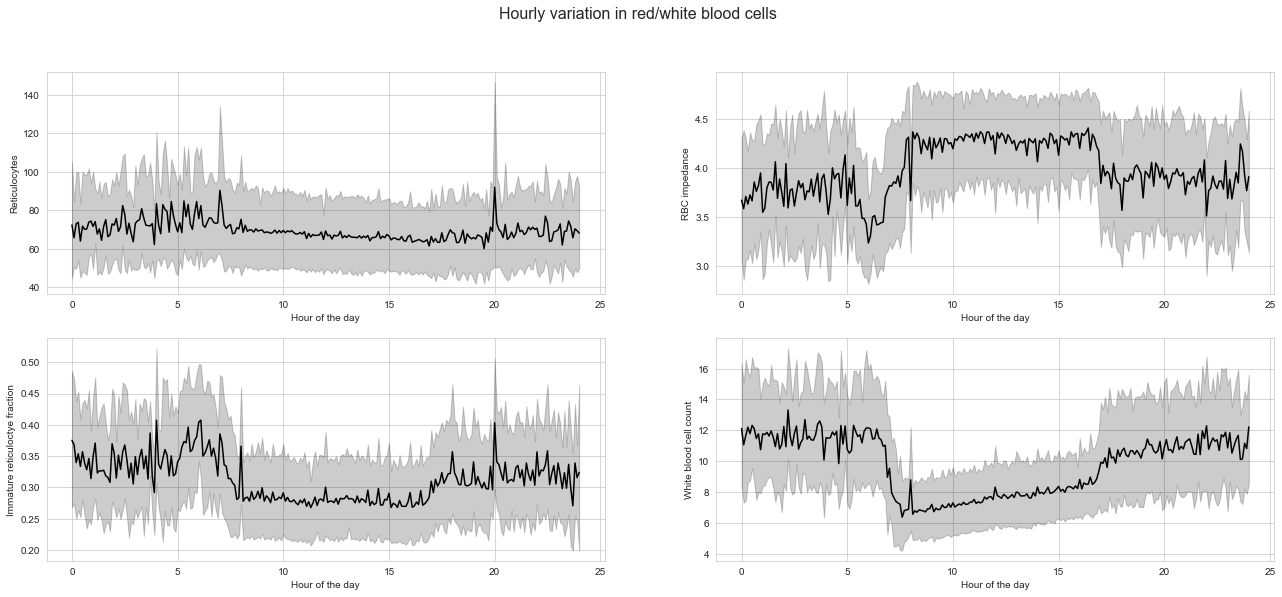

In [15]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_retc.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_rbci.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_irf.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_wbc.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

plot_df.rename(columns={'level_1': 'percentile'}, inplace=True)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_retc', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_rbci', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_irf', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_wbc', color='black', ax=ax[1,1])

ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Reticulocytes')
ax[0,1].set_ylabel('RBC impedance')
ax[1,0].set_ylabel('Immature reticuloctye fraction')
ax[1,1].set_ylabel('White blood cell count')

plt.suptitle('Hourly variation in red/white blood cells ', fontsize=16)

Text(0.5, 0.98, 'Hourly variation in platelets ')

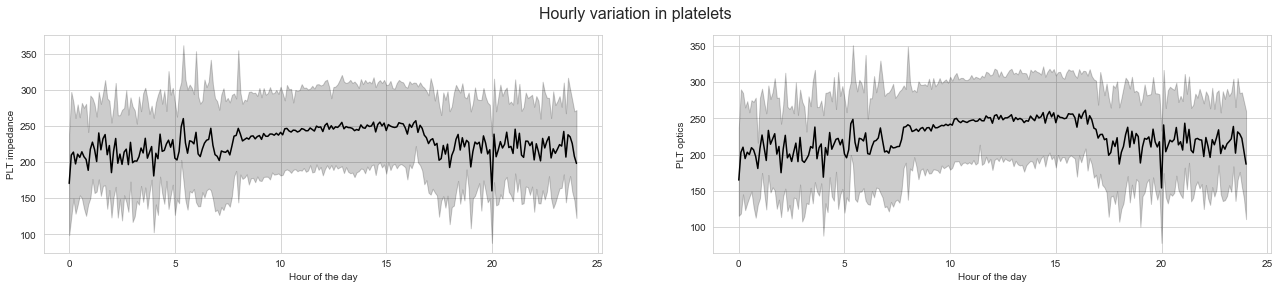

In [16]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_plti.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_plto.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(22,4))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plti', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plto', color='black', ax=ax[1])

ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')

ax[0].set_ylabel('PLT impedance')
ax[1].set_ylabel('PLT optics')

plt.suptitle('Hourly variation in platelets ', fontsize=16)

Text(0.5, 0.98, 'Hourly variation of aggregate blood parameters ')

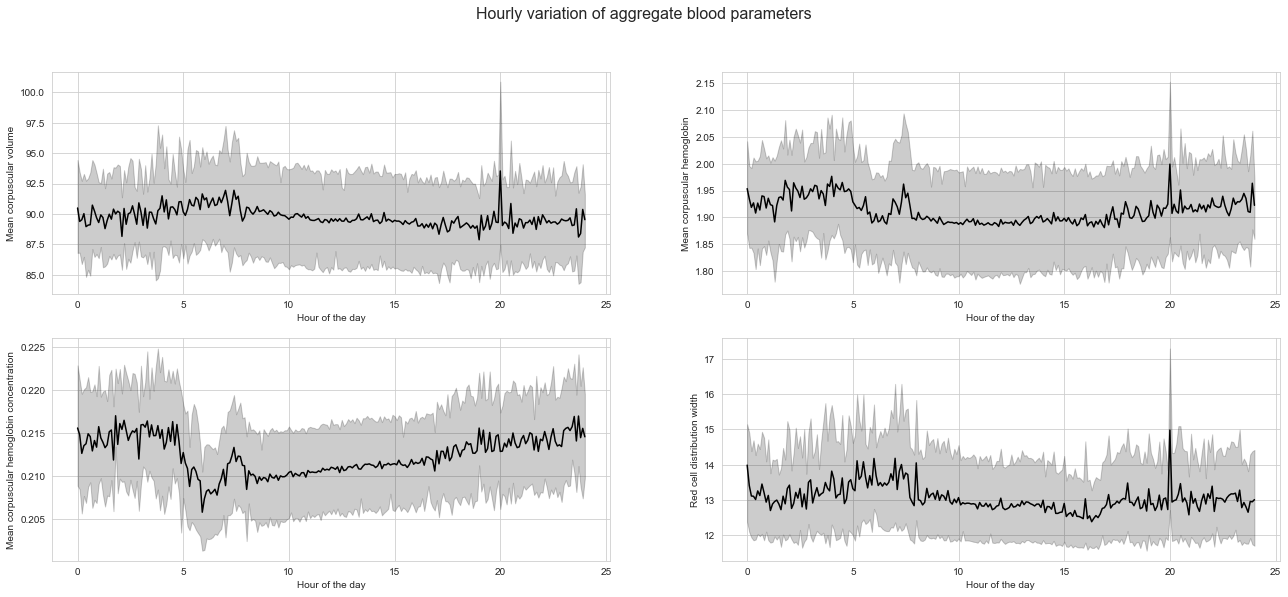

In [17]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_mcv.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_mch.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_mchc.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_rdw.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
          
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mcv', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mch', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mchc', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_rdw', color='black', ax=ax[1,1])


ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Mean corpuscular volume')
ax[0,1].set_ylabel('Mean corpuscular hemoglobin')
ax[1,0].set_ylabel('Mean corpuscular hemoglobin concentration')
ax[1,1].set_ylabel('Red cell distribution width')

plt.suptitle('Hourly variation of aggregate blood parameters ', fontsize=16)

Text(0.5, 0.98, 'Hourly variation in platelets ')

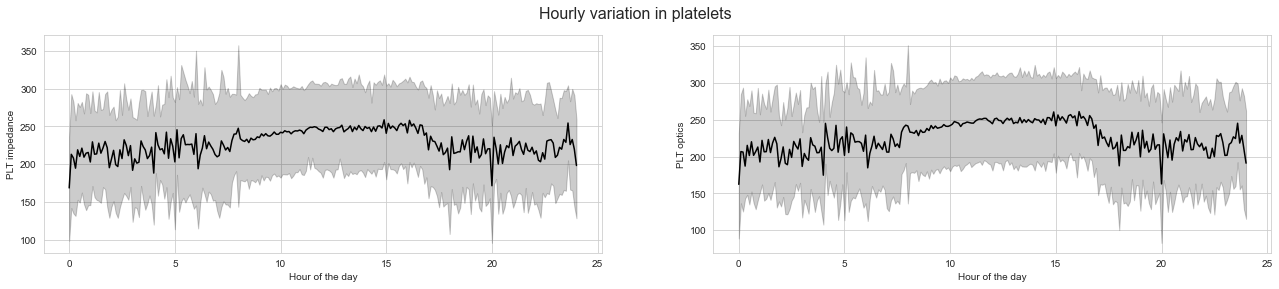

In [18]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_plti.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_plto.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(22,4))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plti', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plto', color='black', ax=ax[1])

ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')

ax[0].set_ylabel('PLT impedance')
ax[1].set_ylabel('PLT optics')

plt.suptitle('Hourly variation in platelets ', fontsize=16)

In [19]:
# wbc/(retc+irf), neu/seg, lym/mon, wbc/plti, plti/(retc+irf), wbc/(mon+lym), ig/(bas+neu+eos), retc/hb, wbc/rbci, rbci/(retc+irf)

celldyn = celldyn.assign(wbc_over_rbc=0.5*celldyn.c_b_wbc/(celldyn.c_b_rbci+celldyn.c_b_rbco))
celldyn = celldyn.assign(neu_over_seg=celldyn.c_b_neu/celldyn.c_b_seg)
celldyn = celldyn.assign(neu_over_wbc=celldyn.c_b_neu/(celldyn.c_b_wbc-celldyn.c_b_neu))
celldyn = celldyn.assign(lym_over_mon=celldyn.c_b_lym/celldyn.c_b_mon)
celldyn = celldyn.assign(wbc_over_plt=celldyn.c_b_wbc/celldyn.plt) # plti, plto
celldyn = celldyn.assign(plt_over_rbc=0.5*celldyn.plt/(celldyn.c_b_rbci+celldyn.c_b_rbco))
celldyn = celldyn.assign(retc_over_hb=celldyn.c_b_retc/celldyn.c_b_hb)
celldyn = celldyn.assign(rbc_over_irbc=celldyn.c_b_rbci/(celldyn.c_b_retc+celldyn.c_b_irf))
celldyn = celldyn.assign(plt_over_lym=celldyn.plt/celldyn.c_b_lym)

Text(0.5, 0.98, 'Hourly variation of hematology ratios ')

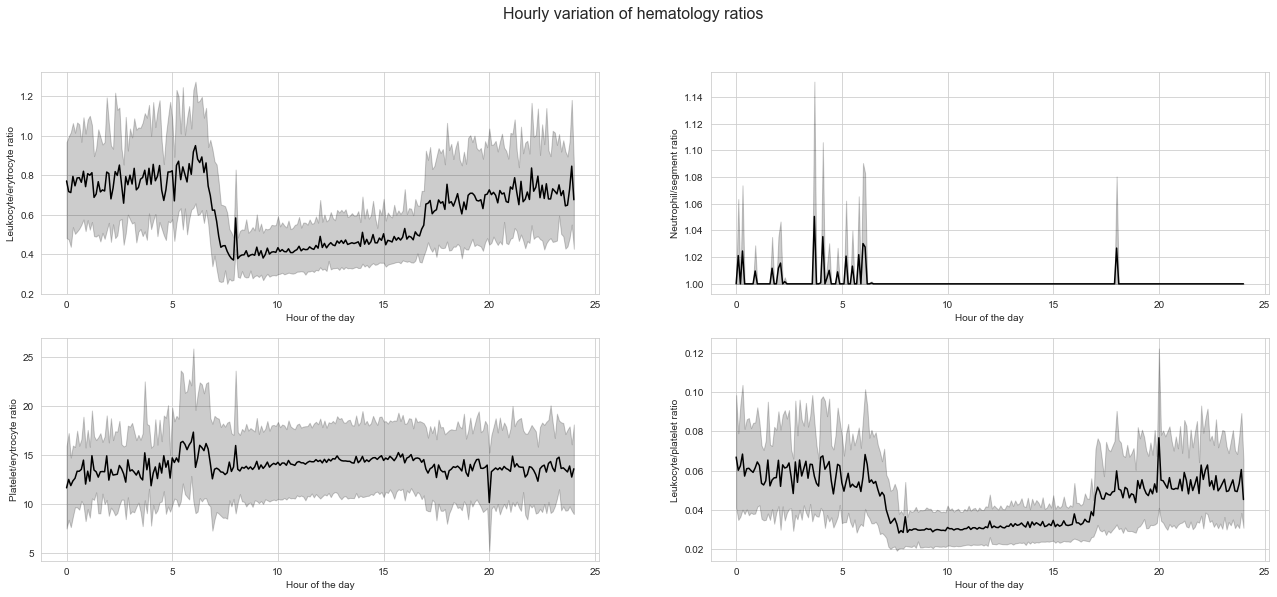

In [20]:
# wbc_over_rbc
# neu_over_seg
# plt_over_rbc
# wbc_over_plt

plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').wbc_over_rbc.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').neu_over_seg.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').plt_over_rbc.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').wbc_over_plt.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
          
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='wbc_over_rbc', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='neu_over_seg', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='plt_over_rbc', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='wbc_over_plt', color='black', ax=ax[1,1])


ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Leukocyte/erytrocyte ratio')
ax[0,1].set_ylabel('Neutrophil/segment ratio')
ax[1,0].set_ylabel('Platelet/erytrocyte ratio')
ax[1,1].set_ylabel('Leukocyte/platelet ratio')

plt.suptitle('Hourly variation of hematology ratios ', fontsize=16)

Text(0.5, 0.98, 'Hourly variation of hematology ratios ')

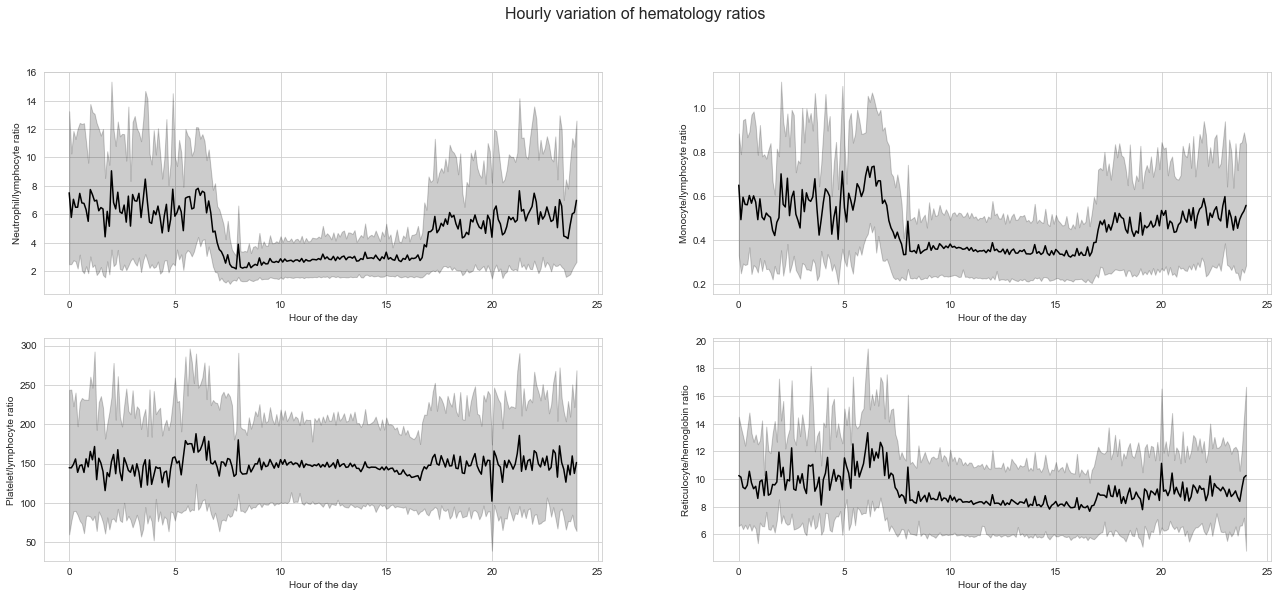

In [21]:
# 'neu:lym'
# 'mon:lym'
#  plt_over_lym
#  retc_over_hb

plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec')['neu:lym'].quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec')['mon:lym'].quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').plt_over_lym.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').retc_over_hb.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
          
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='neu:lym', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='mon:lym', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='plt_over_lym', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='retc_over_hb', color='black', ax=ax[1,1])


ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Neutrophil/lymphocyte ratio')
ax[0,1].set_ylabel('Monocyte/lymphocyte ratio')
ax[1,0].set_ylabel('Platelet/lymphocyte ratio')
ax[1,1].set_ylabel('Reticulocyte/hemoglobin ratio')

plt.suptitle('Hourly variation of hematology ratios ', fontsize=16)

In [22]:
meas_cols.extend(['wbc_over_rbc', 'neu_over_seg', 'lym_over_mon', 'wbc_over_plt', 'neu_over_wbc',
                  'plt_over_rbc', 'retc_over_hb', 'rbc_over_irbc', 'plt_over_lym'])

## Reduce dimensionality

In [63]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline

In [71]:
reduced_dimensions = 3
# manhattan: 40s, 50.000 samples
# poincarre: 4m, 50.000 samples
# fractional_distance: 2m, 50.000 samples
dist = fractional_distance # fractional_distance, poincarre_dist, manhattan, hyperboloid_dist
reducer = UMAP(n_components=3, n_neighbors=50, n_jobs=8, min_dist=0, metric=dist, densmap=False)
emb_cols = [f'dim_{i}' for i in range(reduced_dimensions)]

sample_index = celldyn.dropna(subset=meas_cols).sample(250000).index
celldyn_embedded = celldyn.loc[sample_index, meta_cols].copy()
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    ('Scaling Q', QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=42)),
    ('Embedder', reducer),
])
celldyn_embedded.loc[:, emb_cols] = reduce_pipe.fit_transform(celldyn.loc[sample_index, meas_cols])
celldyn_embedded = celldyn_embedded.assign(normal_prick=celldyn_embedded.draw_hour==8)

In [55]:
import plotly.express as px

In [72]:
fig = px.scatter_3d(celldyn_embedded.sample(10000), x='dim_0', y='dim_1', z='dim_2',
                    color='age', size_max=7, opacity=0.15)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

Text(0.5, 0.98, 'Hourly variation of embedded values ')

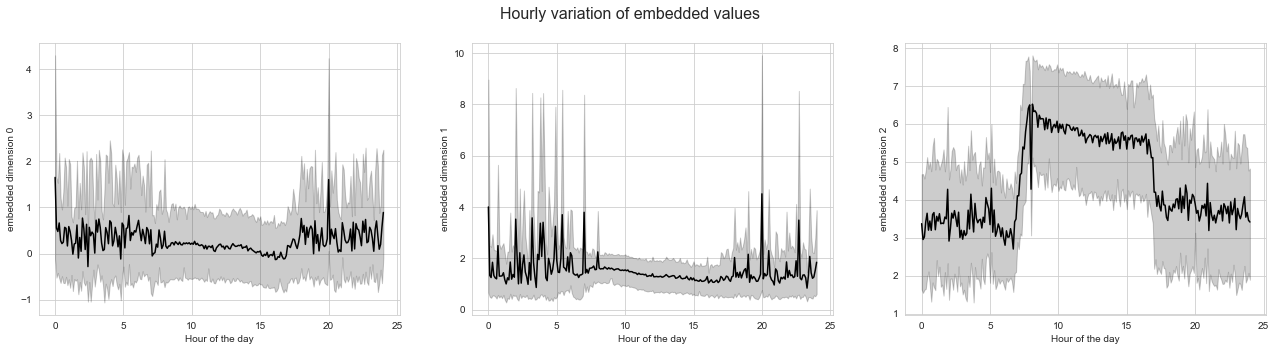

In [79]:
plot_df = celldyn_embedded.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').dim_0.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').dim_1.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').dim_2.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

          
fig, ax = plt.subplots(ncols=3, figsize=(22,5))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='dim_0', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='dim_1', color='black', ax=ax[1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='dim_2', color='black', ax=ax[2])


ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')
ax[2].set_xlabel('Hour of the day')

ax[0].set_ylabel('embedded dimension 0')
ax[1].set_ylabel('embedded dimension 1')
ax[2].set_ylabel('embedded dimension 2')

plt.suptitle('Hourly variation of embedded values ', fontsize=16)